In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib.dates as dates
from datetime import datetime

from dataset import Dataset


## The dataset

The dataset we're working with covers a variety of cabs rides for Uber & Lyft and their prices for the given location. 
Dataset source: https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices?rvi=1
The dataset has 573k instances and 9 columns each but we would be filtering it down to 13k to easily train the model.
We will be working with the following columns:
* distance (distance between source and destination)              
* cab_type (Uber or Lyft)            
* destination         
* source              
* surge_multiplier (the multiplier by which price was increased, default 1)  
* name                
* price (price estimate for the ride in USD)               


In [2]:
load_dataset = pd.read_csv("cab_rides.csv")

Datas = Dataset(load_dataset)
dataset = Datas.getDataset()

In [3]:
# Getting all outliers
outliers_list = Datas.get_outliers()
surge_multiplier_outliers = outliers_list[0]
price_outliers =  outliers_list[1]

print(surge_multiplier_outliers, price_outliers)

                         distance cab_type              destination  \
time_stamp                                                            
2018-11-26 09:44:09.814      2.57     Lyft         Theatre District   
2018-11-26 10:56:09.684      2.31     Lyft         Haymarket Square   
2018-11-26 14:05:11.002      0.61     Lyft            South Station   
2018-11-26 16:41:09.717      2.65     Lyft              Beacon Hill   
2018-11-26 16:59:09.923      0.42     Lyft            South Station   
...                           ...      ...                      ...   
2018-12-18 12:05:11.882      2.79     Lyft       Financial District   
2018-12-18 14:15:13.025      3.40     Lyft  Northeastern University   
2018-12-18 15:20:12.510      1.20     Lyft         Haymarket Square   
2018-12-18 17:30:06.441      0.59     Lyft       Financial District   
2018-12-18 18:20:13.899      1.25     Lyft                North End   

                                          source  surge_multiplier  \
time_s

<h2>Data Presentation</h2>

In [4]:
dataset.head()

,distance,cab_type,destination,source,surge_multiplier,name,price
time_stamp,,,,,,,
2018-11-26 03:40:46.422,0.56,Uber,Haymarket Square,North Station,1.00,UberX,7.0
2018-11-26 03:40:46.551,3.06,Lyft,West End,Boston University,1.00,Lyft,10.5
2018-11-26 03:40:46.971,6.26,Uber,South Station,Back Bay,1.00,Black,34.0
2018-11-26 04:40:56.339,0.66,Lyft,Financial District,South Station,1.25,Lyft,9.0
2018-11-26 04:40:56.854,2.48,Uber,South Station,Beacon Hill,1.00,UberXL,14.0


Loading BokehJS ...

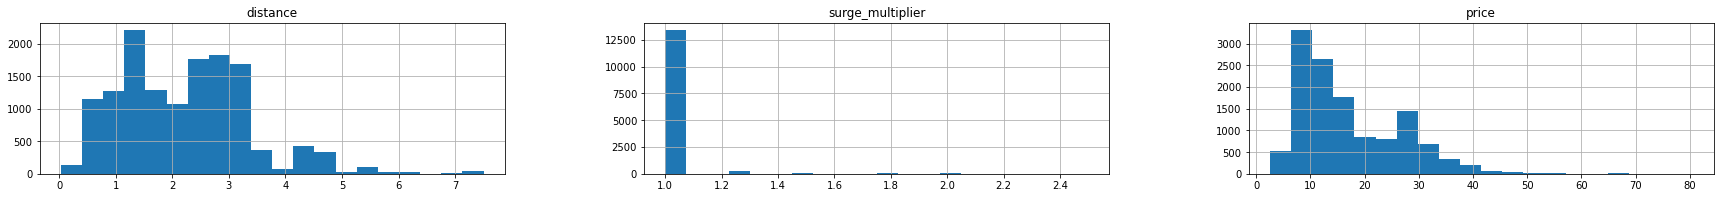

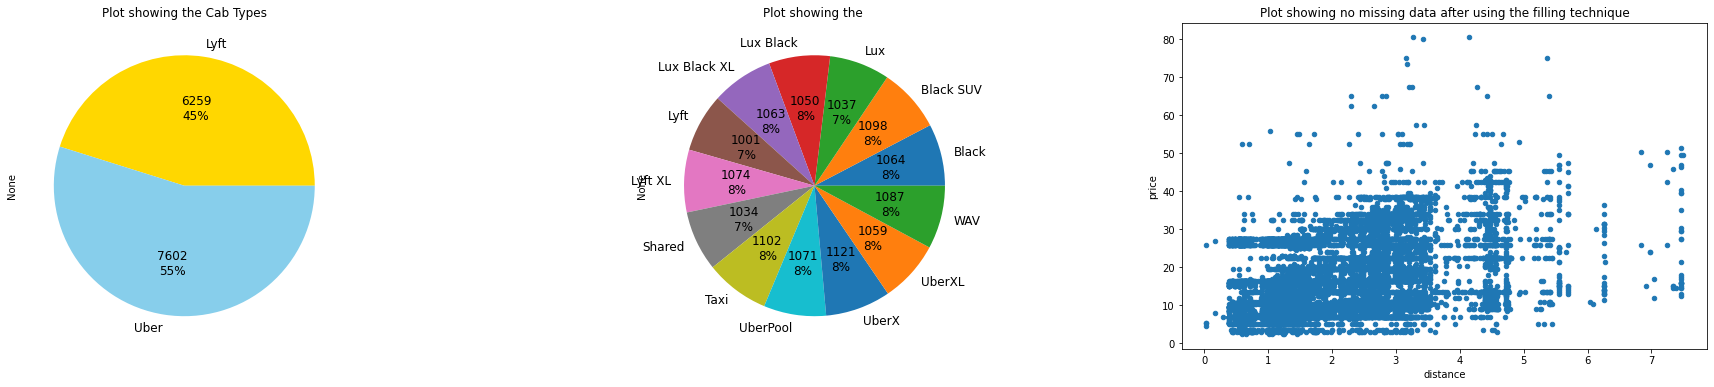

In [5]:
from dataset_plt import DatasetPlot

dataset_plot =  DatasetPlot(dataset)
dataset_plot.plot_dataset()

In [6]:
dataset_plot.bokeh_plot()

<h3>Discussion of Data Visualization</h3>
* Fig 1: Histogram plot of distance. It gives a sense of the frequency distribution of teh ride distance. From the plot we can see that the most frequent ride distance is about 1.5km and the frequencies of long rides above 3.5km is very scarce.<br/><br/>
* Fig 2: Histogram plot of the surge multiplier. This shows the frequency distribution of the surge multiplier. From the plot we can see that on most occassion there is no surge as the default surge multiplier is 1 and on very rare occassions there can be surges above 1.0.<br/><br/>
* Fig 3: Histogram plot of price. This shows the frequency distribution of the price. From the plot we can deduce that most of the cab rides are less than USD 20. <br/><br/>
* Fig 4: Pie Chart plot: This shows the frequency distribution of the cab_types based on the categories. From the plot we can see that we have two categories of cab types: Uber and Lyft. With Uber having 10% more cab rides in this sample than Lyft.<br/><br/>
 * Fig 5: Pie Chart plot:  This shows the frequency distribution of the name based on the categories.<br/></br>
* Fig 6: Scatter plot: Shows the relationship between the distance and price.

<h3>Treating outliers as missing data values in the dataset</h2>

In [7]:
Datas.set_outliers_to_nan()

<h3>Data pre processing and Prediction</h3>

In [9]:
from dataset_processing import DatasetProcessing
data_processing = DatasetProcessing(dataset)
data_processing.predict_price_and_surge()
results =  data_processing.getResult()

## Output result in CSV and HDF

In [10]:
from dataset_output import DatasetOutput

price_result_output = DatasetOutput(results[0])
surge_result_output = DatasetOutput(results[1])

price_result_output.csvOutput('price_predictions.csv')
surge_result_output.csvOutput('surge_predictions.csv')

price_result_output.hd5Output('price_predictions.h5', 'p')
surge_result_output.hd5Output('surge_predictions.h5', 's')